In [1]:
from numpy import ndarray,array, transpose
from carabao.neurotron import Monitor
from carabao.matrix import Attribute, Matrix, Field, rand, sum, zeros
from carabao.util import repr
from carabao.map import Map


In [2]:
#=========================================================================
# class Out
#=========================================================================

class Out:
    def __init__(self,cluster,i,j,tag):
        self.cluster = cluster
        self.i = i
        self.j = j
        self.tag = tag

    def out(self):
        data = self.cluster.get(self.tag)
        return data[self.i,self.j]


class Cell(Attribute):
    def __init__(self,cluster,i,j):
        """
        class Cell: access state attributes of cells[i,j]
        >>> cell = Cell(Cells(),1,1)
        >>> cell.u = 1
        """
        #self.u = Out(cluster,i,j,'U')
        tags = ['u','q','d','b','x','y','s','l']
        for ch in tags:
            self.set(ch,Out(cluster,i,j,ch.upper()))
        self.predict = None

    def state(self):
        tags = ['b','d','l','q','s','u','x','y']
        dict = {}
        for tag in tags:
            dict[tag] = self.get(tag).out()
        return dict

#=========================================================================
# class Cluster
#=========================================================================

class Cluster(Attribute):
    verbose = 0
    def __init__(self,m=4,n=10,d=2,s=5,f=7):
        self.shape = (m,n,d,s)
        self.sizes = (f,n*m)
        self.eta = 0.5
        self.theta = 3
        self.delta = (0.1,0.1)
        
        self.P = Field(m,n,d,s)           # prediction permanences
        self.K = self.tensor(m,n,d,s)     # prediction indices
        self.I = Field(m,n,d,s)           # learning increment
        self.F = self.tensor(m,n,1,f)     # excitation weights
        self.G = self.tensor(m,n,1,m-1)   # collaboration weights
        
        self.U = Matrix(m,n)
        self.Q = Matrix(m,n)
        self.D = Matrix(m,n)
        self.B = Matrix(m,n)
        self.X = Matrix(m,n)
        self.Y = Matrix(m,n)
        self.S = Matrix(m,n)
        self.L = Matrix(m,n)

    def zeros(self,d,s):
        return [[0 for j in range(s)] for i in range(d)]
    
    def tensor(self,m,n,d,s):
        return [[self.zeros(d,s) for j in range(n)] for i in range(m)]
            
    def kappa(self,i,j=None):
        """
        self.kappa():  convert matrix indices to linear index or vice versa
        >>> o = Cluster(m=4,n=10)
        >>> k = o.kappa(i:=1,j:=3)  # k = i+j*m 
        13
        >>> ij = o.kappa(k:=13)    # i = k%m, j = k//m
        (1,3)
        """

        m,n,d,s = self.shape
        if j is None:
            k = i
            return (k%m,k//m)
        else:
            return i + j*m

    def state(self,i,j):
        tags = ['B','D','L','Q','S','U','X','Y']
        s = Matrix(1,len(tags))
        for k in range(len(tags)):
            s[k] = self.get(tags[k])[i,j]
        return s
    
    def setP(self,i,j,P):
        #assert isinstance(P,list) and isinstance(P[0],list) 
        assert isinstance(P,Matrix)
        self.P[i,j] = P

    def setK(self,i,j,K):
        assert isinstance(K,list) and isinstance(K[0],list) 
        self.K[i][j] = K.copy()

    def setG(self,i,j,G):
        assert isinstance(G,list) and isinstance(G[0],list) 
        self.G[i][j] = G.copy()
    
    def initG(self):
        m,n,d,s = self.shape
        for i in range(m):
            for j in range(n):
                g = []
                for nu in range(m):
                    k = self.kappa(nu,j)
                    if nu != i: g.append(k)
                self.setG(i,j,[g])

    def initK(self):
        #rg = Random(seed=0)             # create random generator
        m,n,d,s = self.shape
        N = m*n
        for i in range(m):
            for j in range(n):
                K = self.zeros(d,s)
                for mu in range(d):
                    for nu in range(s):
                        K[mu][nu] = rand(N)
                self.setK(i,j,K)

    def initP(self):
        m,n,d,s = self.shape
        Q = 20                          # quantizing constant
        M = (1+rand((m*d,n*s),Q))/Q
        self.P.set(M)

    def initF(self,f=(7,4)):            # init pooler
        m,n,d,s = self.shape
        ft,fs = f                       # ft: total bits, fs: sparse bits
        self.F = self.tensor(m,n,1,ft)  # excitation weights
        tokens = {}
        for j in range(n):
            while True:
                w = [0 for k in range(ft)]
                for k in range(fs):
                    w[rand(ft)] = 1
                if sum(w) == fs:
                    key = ''
                    for k in range(ft):
                        key += '1' if w[k] else '0'
                    if key in tokens:
                        continue
                    tokens[key] = True
                    break
            for i in range(m):        
                self.F[i][j][0] = w

    def init(self):
        self.initP()
        self.initK()
        self.initG()
        self.initF()
        return self

    def smap(self,label=''):
        m,n,d,s = self.shape
        S = Field(m,n,1,8)
        for i in range(m):
            for j in range(n):
                S[i,j] = self.state(i,j)
        S.smap(label)

    def wmap(self,label=''):
        m,n,d,s = self.shape
        W = Field(m,n,d,s)
        for i in range(m):
            for j in range(n):
                Wij = self.P[i,j] >= self.eta
                W[i,j] = Wij
        W.imap(label)
        
    def map(self):
        Map(self).Kmap()
        #Map(self).Pmap()
        self.P.vmap('P: ')
        #Map(self).Wmap()
        self.wmap('W: ')
        Map(self).Gmap()

    def stimu(self,y):
        M,N = self.sizes
        m,n,d,s = self.shape
        c = y[:N];  f = y[N:N+M]
        for i in range(m):
            for j in range(n):
                e = (array(self.F[i][j][0])*array(f))
                self.U[i,j] = int(e.sum() >= 3)
                #print('U[%g,%g]:' % (i,j),self.U[i][j])
        return y

    def react(self,y):
        M,N = self.sizes
        m,n,d,s = self.shape
        c = y[:N];  f = y[N:N+M]
        for i in range(m):
            for j in range(n):
                self.Y[i,j] = self.U[i,j] * self.X[i,j]
                k = self.kappa(i,j)
                y[k] = self.Y[i,j]
                self.L[i,j] = self.X[i,j] * self.Y[i,j]
                if self.L[i,j]:
                    _Pij = self.P[i,j]
                    for mu in range(d):
                        for nu in range(s):
                            self.P[i,j][mu,nu] += self.I[i,j][mu,nu] 
                            self.P[i,j][mu,nu] = max(0,min(1,self.P[i,j][mu,nu]))
                    Pij = self.P[i,j]
                    if self.verbose > 0:
                        print('learn P[%g,%g]:' % (i,j),_Pij,'=>',Pij)
        return y

    def depress(self,y):
        M,N = self.sizes
        m,n,d,s = self.shape
        c = y[:N];  f = y[N:N+M]
        for i in range(m):
            for j in range(n):
                g = self.G[i][j][0]
                v = g.copy()
                for nu in range(len(g)):
                    k = g[nu]
                    v[nu] = c[k]   
                e = array(v)
                self.D[i,j] = int(e.sum() > 0)
                self.L[i,j] = 0
                #print('D[%g,%g]:' % (i,j),self.D[i][j])
        return y

    def excite(self,y):
        M,N = self.sizes
        m,n,d,s = self.shape
        c = y[:N];  f = y[N:N+M]
        for i in range(m):
            for j in range(n):
                self.Q[i,j] = self.U[i,j]
        return y

    def burst(self,y):
        M,N = self.sizes
        m,n,d,s = self.shape
        c = y[:N];  f = y[N:N+M]
        for i in range(m):
            for j in range(n):
                self.B[i,j] = int(not self.D[i,j] and self.Q[i,j])
                self.Y[i,j] = int(self.Y[i,j] or self.B[i,j])
                k = self.kappa(i,j)
                y[k] = self.Y[i,j]
        return y

    def predict(self,y):
        M,N = self.sizes
        m,n,d,s = self.shape
        c = y[:N];  f = y[N:N+M]
        for i in range(m):
            for j in range(n):
                K = self.K[i][j]
                P = self.P[i,j]
                V = array(self.zeros(d,s))
                W = array(self.zeros(d,s))
                E = array(self.zeros(d,s))
                for mu in range(d):
                    for nu in range(s):
                        k = K[mu][nu]
                        V[mu][nu] = c[k]
                        W[mu][nu] = int(P[mu,nu] >= 0.5)
                        E[mu][nu] = V[mu][nu] * W[mu][nu]
                #spike = [0 for mu in range(d)]
                #for mu in range(d):
                #    spike[mu] = int(sum(E[mu]) >= self.theta)
                E = Matrix(E);
                #print('##### E:',E,'sum(E.T):',sum(E.T))
                spike = sum(E.T) >= self.theta
                #print('##### spike:',spike)
                
                self.S[i,j] = array(spike).max()
                #print('V:',V,'W:',W,'E:',E,'spike:',spike)
                self.X[i,j] = self.S[i,j]
                if self.S[i,j]:
                    pdelta,ndelta = self.delta
                    
                    for mu in range(d):
                        for nu in range(s):
                            self.I[i,j][mu,nu] = spike[mu]*(2*pdelta*V[mu,nu] - ndelta)
        return y

    def relax(self,y):
        M,N = self.sizes
        m,n,d,s = self.shape
        c = y[:N];  f = y[N:N+M]; Z = zeros(m,n)
        self.set('U,Q,D,B,Y,S',(Z,Z,Z,Z,Z,Z))
        #for i in range(m):
        #    for j in range(n):
        #        self.U[i,j] = 0
        #        self.Q[i,j] = 0
        #        self.D[i,j] = 0
        #        self.B[i,j] = 0
        #        self.Y[i,j] = 0
        #        self.S[i,j] = 0
        for i in range(m):
            for j in range(n):
                k = self.kappa(i,j)
                y[k] = self.Y[i,j]
        return y

    def idle(self):
        m,n,d,s = self.shape
        for i in range(m):
            for j in range(n):
                self.U[i,j] = 0
                self.Q[i,j] = 0
                self.D[i,j] = 0
                self.B[i,j] = 0
                self.Y[i,j] = 0
                self.S[i,j] = 0
                self.X[i,j] = 0
                self.L[i,j] = 0
                k = self.kappa(i,j)
                y[k] = self.Y[i,j]
        return y
        

    def plot(self,mon,subplot=0,title=None):
        m,n,d,s = self.shape
        for i in range(m):
            for j in range(n):
                cell = Cell(self,i,j)
                mon(cell,i+subplot*(m+1),j)
        if title is not None:
            mon.title(title)

    def apply(self,y,tag='',log=None,all=None):
        m,n,d,s = self.shape
        y = self.stimu(y);
        prefix = tag + ' - ' if tag != '' else ''
        if log is not None:
            print('stimu ...');  Map(cells).Smap()
        if all is not None:
            mon = Monitor(2*m+1,n); 
            cells.plot(mon,0);  mon.title(prefix+'stimu')

        y = self.react(y);
        if log is not None:
            print('ract ...');  Map(cells).Smap()
        if all is not None:
            cells.plot(mon,1);  mon.xlabel(n/2-0.5,prefix+'react')
        else:
            mon = Monitor(2*m+1,n); 
            cells.plot(mon,0);  mon.title(prefix+'react')
        
        y = cells.depress(y);
        if log is not None:
            print('depress ...');  Map(cells).Smap()
        if all is not None:
            mon = Monitor(2*m+1,n); 
            cells.plot(mon,0);  mon.title(prefix+'depress')
        
        y = cells.excite(y);
        if log is not None:
            print('excite ...');   Map(cells).Smap()
        if all is not None:
            cells.plot(mon,1);  mon.xlabel(n/2-0.5,prefix+'excite')

        y = cells.burst(y);
        if log is not None:
            print('burst ...');    Map(cells).Smap()
        if all is not None:
            mon = Monitor(2*m+1,n); 
            cells.plot(mon,0);  mon.title(prefix+'burst')
        
        y = cells.predict(y);  
        if log is not None:
            print('predict ...');  Map(cells).Smap()
        if all is not None:
            cells.plot(mon,1);  mon.xlabel(n/2-0.5,prefix+'predict')
        else:
            cells.plot(mon,1);  mon.xlabel(n/2-0.5,prefix+'predict')
        
        y = cells.relax(y);
        if log is not None:
            print('relax ...');    Map(cells).Smap()
        if all is not None:
            mon = Monitor(2*m+1,n); 
            cells.plot(mon,0);  mon.title(prefix+'relax')
        return y        

#==========================================================================================================
# tokenizer
#==========================================================================================================


token = {'Mary': [1,0,1,1,0,1,0,1],
         'John': [1,1,0,0,1,0,1,1],
         'likes':[0,1,1,0,1,0,1,1],
         'to':   [1,1,0,1,0,0,1,1],
         'sing': [0,1,0,0,1,1,1,1],
         'dance':[0,0,1,1,0,1,1,1],
         '.':    [0,1,1,0,1,1,1,0],
        }


K: +-000/0-+-006/6-+-012/C-+-018/I-+-024/O-+-030/U-+-036/a-+-042/g-+-048/m-+-054/s-+
   | hl36r | v8jOC | ZV2Sa | 4h0Ou | 72YJ3 | 3d2qI | mQ4gd | 0MCRi | cssoj | rFomL |
   | uQD1M | eMJNj | 0OaUa | HaLuP | Dd5gI | s2W1h | arxDN | Q5Axg | X09Uh | 6kOCr |
   +-001/1-+-007/7-+-013/D-+-019/J-+-025/P-+-031/V-+-037/b-+-043/h-+-049/n-+-055/t-+
   | 0HPSw | ALNNu | vkUOH | I2Z4R | 6RHsH | bCeuA | biIEb | qFPFb | 9ppML | BFPK1 |
   | lPI38 | v5SZc | ChxOS | fRvDH | xW99j | vKG9m | HMnrk | NH1XT | SW0eq | gpW4i |
   +-002/2-+-008/8-+-014/E-+-020/K-+-026/Q-+-032/W-+-038/c-+-044/i-+-050/o-+-056/u-+
   | SF9MU | qkaW8 | P7EGu | wsOc5 | hx33Q | QvkN5 | 0dcId | 4dxQA | vFBxb | 3rZFr |
   | eEV5N | EGXlZ | HK4TV | raMKX | IjoR3 | vao1V | aMU8a | cRbs0 | jpYjw | o3ofp |
   +-003/3-+-009/9-+-015/F-+-021/L-+-027/R-+-033/X-+-039/d-+-045/j-+-051/p-+-057/v-+
   | sOCg3 | kOS44 | l9U2r | WCL1H | W7n54 | Ig99k | QI0Jm | LEO8B | KdS8W | uZJDi |
   | IoPhx | UnC1l | 6YojX | 1Uc80 | V53IA | eADTj | OtHGU | CVBZ

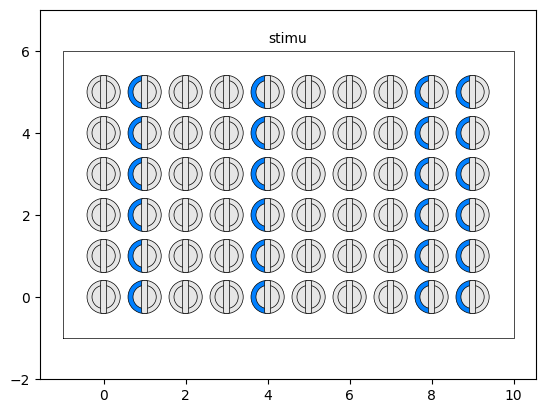

In [3]:
class Cells(Cluster):
    def states(self):
        """
        cells = Cells()
        U = cells.states()
        """
        return (self.U)
        
    def params(self):
        """
        cells = Cells()
        F = cells.params()
        """
        return (self.F)

    def stimu(self,y):
        def trn(list):
            return transpose(array([list]))
        """
        e = F @ f'
        """
        M,N = self.sizes
        m,n,d,s = self.shape
        c = y[:N];  f = y[N:N+M]
        U = self.states();  F = self.params()
        
        fT = trn(f);
        #print("F:\n",F,"f':",fT)
        
        for i in range(m):
            for j in range(n):
                e = (array(F[i][j][0])*array(f))
                U[i,j] = int(e.sum() >= 3)
                #print('U[%g,%g]:' % (i,j),self.U[i][j])
        return y

        
m=6; n = 10
cells = Cells(m,n,2,5).init()
c=[0 for k in range(m*n)]; f = token['Mary']; y = c + f
y = cells.stimu(y)



#Map(cells).Smap(); 
mon=Monitor(m,n); cells.plot(mon,title='stimu')


#state = Matrix([])
cells.map()


In [4]:
cells = Cells();

cells.get('U')[0,0]=0
cells.get('Q')[0,0]=1
cells.get('X')[0,0]=1
cells.get('Y')[0,0]=1
cells.get('B')[0,0]=1
cells.get('S')[0,0]=0
cells.get('L')[0,0]=0

cells.smap('S: ')
cells.P[0,0] = Matrix([[.3,.4,.5,.6,.7],[0,0,.5,.5,1]])
cells.P.vmap('P: ')

S: +-000/0-+-004/4-+-008/8-+-012/C-+-016/G-+-020/K-+-024/O-+-028/S-+-032/W-+-036/a-+
   | QX-BY | ----- | ----- | ----- | ----- | ----- | ----- | ----- | ----- | ----- |
   +-001/1-+-005/5-+-009/9-+-013/D-+-017/H-+-021/L-+-025/P-+-029/T-+-033/X-+-037/b-+
   | ----- | ----- | ----- | ----- | ----- | ----- | ----- | ----- | ----- | ----- |
   +-002/2-+-006/6-+-010/A-+-014/E-+-018/I-+-022/M-+-026/Q-+-030/U-+-034/Y-+-038/c-+
   | ----- | ----- | ----- | ----- | ----- | ----- | ----- | ----- | ----- | ----- |
   +-003/3-+-007/7-+-011/B-+-015/F-+-019/J-+-023/N-+-027/R-+-031/V-+-035/Z-+-039/d-+
   | ----- | ----- | ----- | ----- | ----- | ----- | ----- | ----- | ----- | ----- |
   +-------+-------+-------+-------+-------+-------+-------+-------+-------+-------+
P: +-000/0-+-004/4-+-008/8-+-012/C-+-016/G-+-020/K-+-024/O-+-028/S-+-032/W-+-036/a-+
   | keAEJ | 00000 | 00000 | 00000 | 00000 | 00000 | 00000 | 00000 | 00000 | 00000 |
   | 00AA1 | 00000 | 00000 | 00000 | 00000 | 00000 | 00000 | 0000

In [5]:
cells = Cluster(m,n,2,5).init()
E=Matrix([[0,0,1,0,0],[1,1,0,1,1]]);print(E)
sum(E.T)>=cells.theta

[0 0 1 0 0; 1 1 0 1 1]


[0 1]

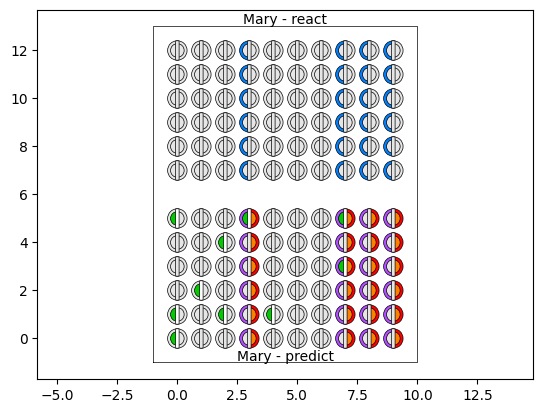

In [6]:

cells = Cluster(m,n,2,5).init()
c=[0 for k in range(m*n)]; f = token['Mary']; y = c + f
y = cells.apply(y,'Mary')


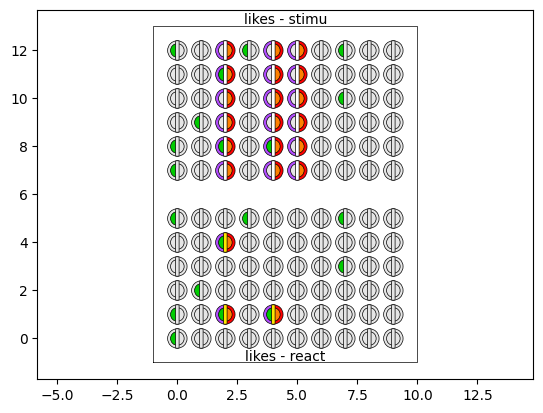

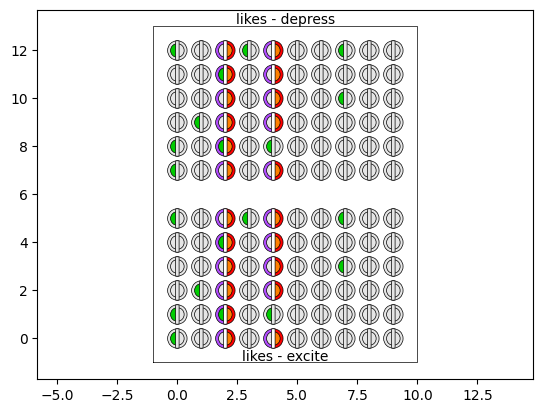

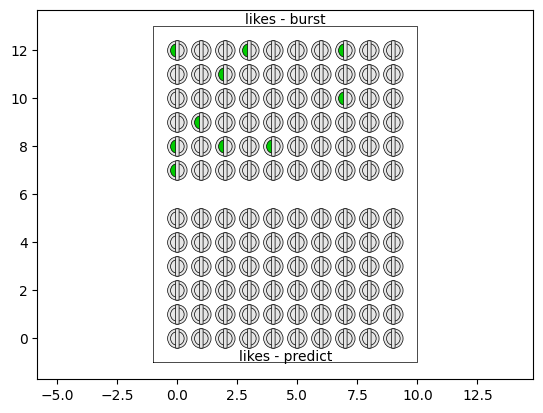

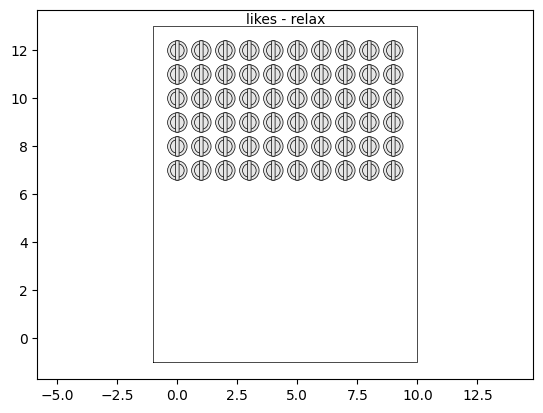

In [7]:
c=[0 for k in range(m*n)]; f = token['likes']; y = c + f
y = cells.apply(y,'likes',all=True)



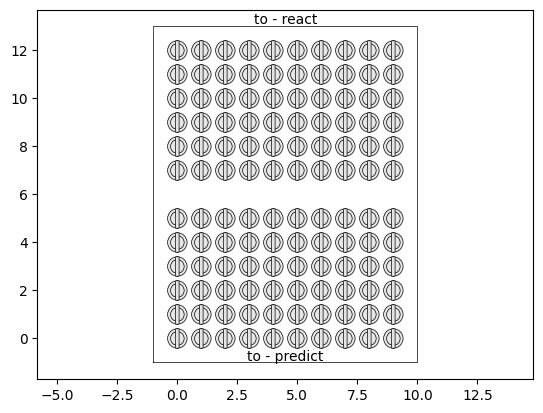

In [8]:
c=[0 for k in range(m*n)]; f = token['to']; y = c + f
y = cells.apply(y,'to')


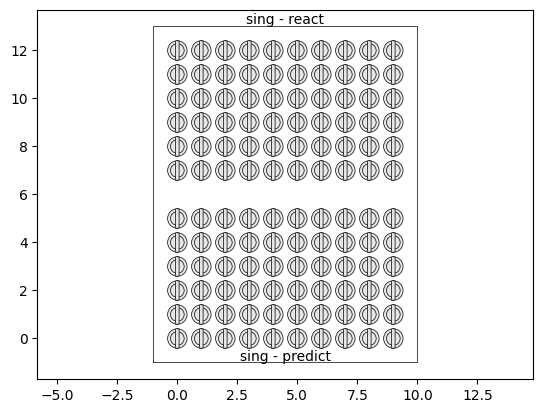

In [9]:
c=[0 for k in range(m*n)]; f = token['sing']; y = c + f
y = cells.apply(y,'sing')


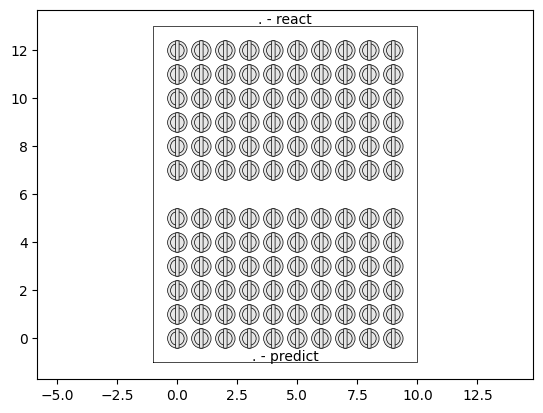

In [10]:
c=[0 for k in range(m*n)]; f = token['.']; y = c + f
y = cells.apply(y,'.')

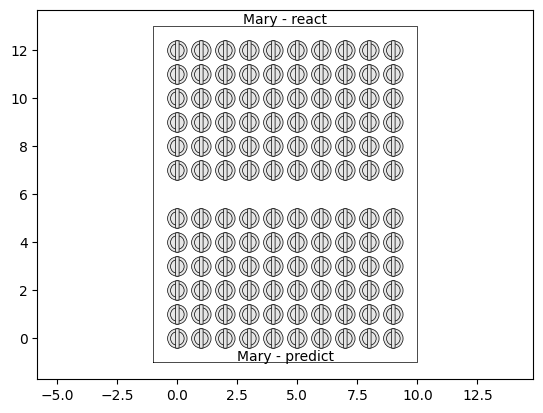

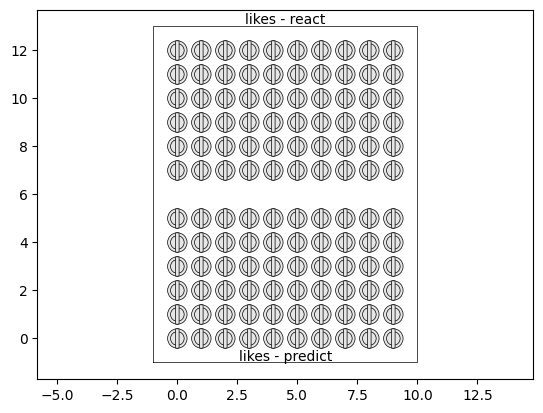

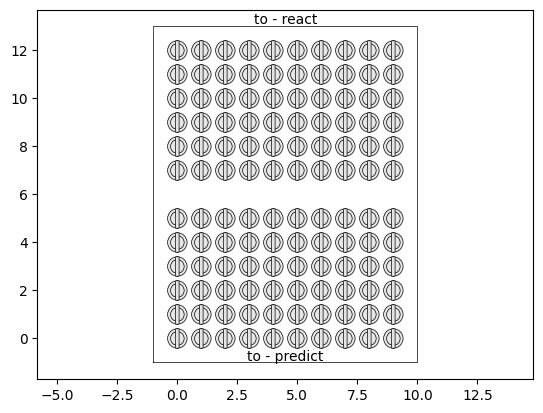

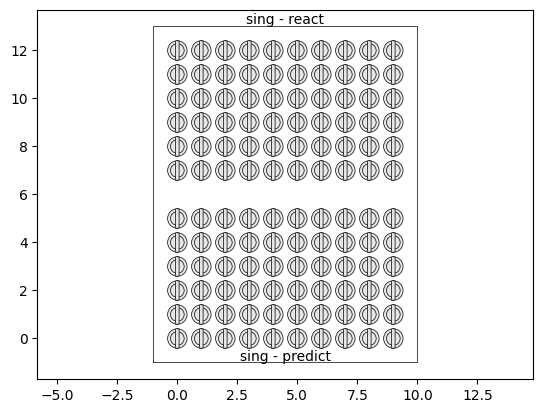

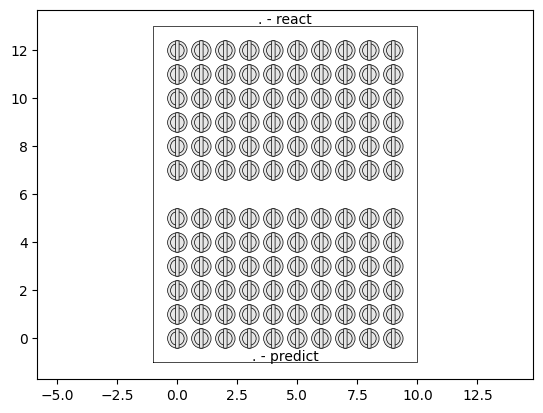

In [11]:
seq = ['Mary','likes','to','sing','.']
cells.idle()
for word in seq:
    c=[0 for k in range(m*n)]; f = token[word]; y = c + f
    y = cells.apply(y,word)